In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pystac_client
import xarray as xr
from odc.geo.geobox import GeoBox
from odc.geo.xr import xr_coords
from rasterio.features import rasterize

from mccn.extent import GeoBoxBuilder

ENDPOINT = "http://115.146.84.224:8082/"
client = pystac_client.Client.open(ENDPOINT)
collection = client.get_collection("vector_data")

In [19]:
area1 = collection.get_item("OZBarley1_layout")
area2 = collection.get_item("OZBarley2_layout")
area1_gdf = gpd.read_file(area1.assets["data"].href)
area1_gdf = area1_gdf.to_crs(4326)
area2_gdf = gpd.read_file(area2.assets["data"].href)
area2_gdf = area2_gdf.to_crs(4326)
gbox = GeoBoxBuilder.from_collection(collection, shape=100)

In [ ]:
from typing import Any, Sequence, Literal
import pandas as pd


def update_attr_legend(
    attr_dict: dict[str, Any], layer_name: str, field: str, frame: gpd.GeoDataFrame
) -> None:
    if pd.api.types.is_string_dtype(frame[field]):
        cat_map = {name: index for index, name in enumerate(frame[field].unique())}
        attr_dict[layer_name] = cat_map
        frame[field] = frame[field].map(cat_map)


def groupby_id(
    data: dict[str, gpd.GeoDataFrame],
    geobox: GeoBox,
    fields: Sequence[str] | dict[str, Sequence[str]] | None = None,
    x_col: str = "x",
    y_col: str = "y",
) -> tuple[dict[str, Any], dict[str, Any]]:
    # Load as pure mask
    if fields is None:
        return {
            key: (
                [y_col, x_col],
                rasterize(
                    value.geometry,
                    geobox.shape,
                    transform=geobox.transform,
                    masked=True,
                ),
            )
            for key, value in data.items()
        }, {}
    # Load as attribute per layer
    # Prepare field for each layer
    item_fields = {}
    if isinstance(fields, dict):
        if set(data.keys()).issubset(set(fields.keys())):
            raise ValueError(
                f"Vector Loader: when groupby id and field is provided as a dictionary, its key must be a superset of ids of all vector items in the collection. {set(data.keys()) - set(fields.keys())}"
            )
        item_fields = fields
    else:
        item_fields = {k: fields for k in data.keys()}

    ds_data = {}
    ds_attrs = {"legend": {}}
    # Field per layer
    for k, frame in data.items():
        for field in item_fields[k]:
            layer_name = f"{k}_{field}"
            update_attr_legend(ds_attrs["legend"], layer_name, field, frame)
            # Build legend mapping for categorical encoding of values
            ds_data[layer_name] = (
                [y_col, x_col],
                rasterize(
                    (
                        (geom, value)
                        for geom, value in zip(frame.geometry, frame[field])
                    ),
                    geobox.shape,
                    transform=geobox.transform,
                ),
            )
    return ds_data, ds_attrs


def load_as_mask(
    data: dict[str, gpd.GeoDataFrame],
    geobox: GeoBox,
    x_col: str = "x",
    y_col: str = "y",
) -> xr.Dataset:
    ds_data = {
        key: (
            [y_col, x_col],
            rasterize(
                value.geometry,
                geobox.shape,
                transform=geobox.transform,
                masked=True,
            ),
        )
        for key, value in data.items()
    }
    coords = xr_coords(geobox, dims=(y_col, x_col))
    return xr.Dataset(ds_data, coords)


def load_fields_per_layer(
    data: dict[str, gpd.GeoDataFrame],
    geobox: GeoBox,
    fields: Sequence[str] | dict[str, Sequence[str]],
    x_col: str = "x",
    y_col: str = "y",
) -> xr.Dataset:
    fields_per_layer = {}
    if isinstance(fields, str):
        fields_per_layer = {k: [fields] for k in data.keys()}
    elif isinstance(fields, dict):
        for k in data.keys():
            if k not in fields:
                raise ValueError(
                    f"Missing fields for item: {k}. When loading vector data as fields per layer and the fields parameter is provided as a dict, it must contain the required fields to process for each vector item."
                )
            # If field is provided as str, convert to list
            if isinstance(fields[k], str):
                fields_per_layer[k] = [fields[k]]
            else:
                fields_per_layer[k] = fields[k]
    # If fields is None, generate each field from each item in a separate band
    elif fields is None:
        excluded_fields = {x_col, y_col, "geometry"}
        for k, frame in data.items():
            fields_per_layer[k] = set(frame.columns) - excluded_fields
    # If fields is a list of string
    elif hasattr(fields, "__len__"):
        fields_per_layer = {k: fields for k in data.keys()}
    else:
        raise ValueError(f"Invalid type for fields: {type(fields)}")
    ds_data = {}
    ds_attrs = {"legend": {}}
    # Field per layer
    for k, frame in data.items():
        for field in fields_per_layer[k]:
            layer_name = f"{k}_{field}"
            # Build legend mapping for categorical encoding of values
            if pd.api.types.is_string_dtype(frame[field]):
                cat_map = {
                    name: index for index, name in enumerate(frame[field].unique())
                }
                ds_attrs["legend"][layer_name] = cat_map
                frame[field] = frame[field].map(cat_map)
            ds_data[layer_name] = (
                [y_col, x_col],
                rasterize(
                    (
                        (geom, value)
                        for geom, value in zip(frame.geometry, frame[field])
                    ),
                    geobox.shape,
                    transform=geobox.transform,
                ),
            )
    coords_ = xr_coords(geobox, dims=(y_col, x_col))
    coords = {
        y_col: coords_[y_col],
        x_col: coords_[x_col],
        "spatial_ref": coords_["spatial_ref"],
    }
    return xr.Dataset(ds_data, coords, ds_attrs)


def groupby_field(
    data: dict[str, gpd.GeoDataFrame],
    geobox: GeoBox,
    fields: Sequence[str],
    alias_renaming: dict[str, tuple[str, str]] | None = None,
    x_col: str = "x",
    y_col: str = "y",
) -> xr.Dataset:
    if fields is None: 
        raise ValueError("When groupby field, fields parameter must not be None")
    # Rename columns based on alias map 
    if alias_renaming:
        for field, (item_id, item_column) in alias_renaming:
            data[item_id].rename(columns={item_column: field}, inplace=True)
    if isinstance(fields, str):
        fields = [fields]
    gdf = pd.concat(data.values())
    ds_data = {}
    ds_attrs = {}
    for field in fields:
        if pd.api.types.is_string_dtype(gdf[field]):
            cat_map = {name: index for index, name in enumerate(gdf[field].unique())}
            ds_attrs["legend"][field] = cat_map
            gdf[field] = gdf[field].map(cat_map)
        ds_data[field] = (
            [y_col, x_col],
            rasterize(
                ((geom, value) for geom, value in zip(gdf.geometry, gdf[field])),
                out_shape=geobox.shape,
                transform=geobox.transform,
            ),
        )
    return ds_data, ds_attrs


In [23]:
vds = load_as_mask(
    {"OZBarley1_Layout": area1_gdf, "OZBarley2_Layout": area2_gdf}, geobox=gbox
)
vds

<xarray.Dataset> Size: 162kB
Dimensions:           (y: 100, x: 100)
Coordinates:
  * y                 (y) float64 800B -35.05 -35.05 -35.05 ... -35.05 -35.05
  * x                 (x) float64 800B 147.3 147.3 147.3 ... 147.3 147.3 147.3
    spatial_ref       int32 4B 4326
Data variables:
    OZBarley1_Layout  (y, x) int64 80kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    OZBarley2_Layout  (y, x) int64 80kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 1 1 0

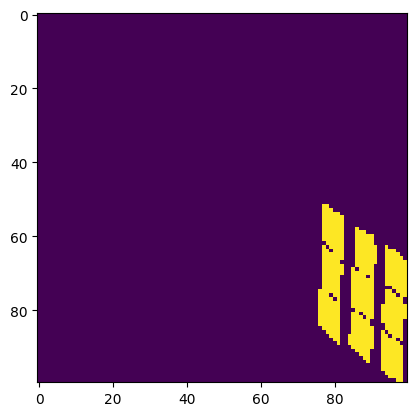

In [25]:
plt.imshow(vds["OZBarley2_Layout"].values)

In [ ]:
vds = load_fields_per_layer(
    {"OZBarley1_Layout": area1_gdf, "OZBarley2_Layout": area2_gdf},
    geobox=gbox,
    fields=None,
)

In [37]:
vds

<xarray.Dataset> Size: 642kB
Dimensions:                   (y: 100, x: 100)
Coordinates:
  * y                         (y) float64 800B -35.05 -35.05 ... -35.05 -35.05
  * x                         (x) float64 800B 147.3 147.3 147.3 ... 147.3 147.3
    spatial_ref               int32 4B 4326
Data variables:
    OZBarley1_Layout_ACCName  (y, x) int64 80kB 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    OZBarley1_Layout_id       (y, x) int64 80kB 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    OZBarley1_Layout_OzB      (y, x) int64 80kB 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    OZBarley1_Layout_AACENUM  (y, x) int64 80kB 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    OZBarley2_Layout_ACCName  (y, x) int64 80kB 0 0 0 0 0 0 0 ... 0 0 0 0 8 8 0
    OZBarley2_Layout_id       (y, x) int64 80kB 0 0 0 0 0 0 0 ... 0 0 0 0 8 8 0
    OZBarley2_Layout_OzB      (y, x) int64 80kB 0 0 0 0 0 0 0 ... 0 0 0 0 8 8 0
    OZBarley2_Layout_AACENUM  (y, x) int64 80kB 0 0 0 0 0 0 0 ... 0 0 0 0 8 8 0
Attributes:
    legend:   {'OZBarley1_Layout_ACCName': {'BARKE': 0, 'LENKA': 1, 'GROUT': ...

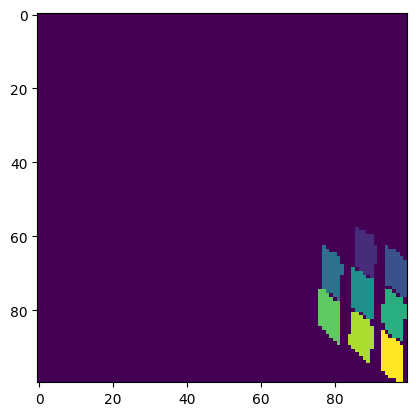

In [39]:
plt.imshow(vds["OZBarley2_Layout_OzB"].values)


In [ ]:
vds = load_groupby_field(
    {"OZBarley1_Layout": area1_gdf, "OZBarley2_Layout": area2_gdf}, gbox, "OzB"
)

In [42]:
vds

<xarray.Dataset> Size: 82kB
Dimensions:      (y: 100, x: 100)
Coordinates:
  * y            (y) float64 800B -35.05 -35.05 -35.05 ... -35.05 -35.05 -35.05
  * x            (x) float64 800B 147.3 147.3 147.3 147.3 ... 147.3 147.3 147.3
    spatial_ref  int32 4B 4326
Data variables:
    OzB          (y, x) int64 80kB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 8 8 0

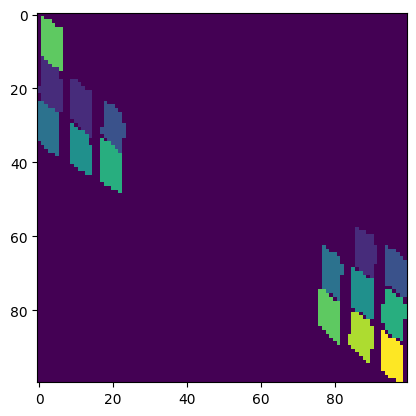

In [43]:
plt.imshow(vds["OzB"].values)

In [44]:
type(vds.coords)

xarray.core.coordinates.DatasetCoordinates

In [ ]:
items = list(collection.get_all_items())
point_items = [items[0], items[2]]

In [ ]:
from mccn.loader import stac_load_point

gbox = (
    GeoBoxBuilder(4326)
    .set_bbox(collection.extent.spatial.bboxes[0])
    .set_shape(1000, 1000)
    .build()
)

pds = stac_load_point(point_items, geobox=gbox)

In [ ]:
point_items

In [ ]:
plt.imshow(pds.Ca_Soln.sel(time="2024-09-5").values[0, :, :])

In [ ]:
pds